In [29]:
from general import *

In [30]:
class MotionNeuron():
    NeuronState = namedtuple('NeuronState', ['V', 'w', 'spk', 'I'])

    def __init__(self, parameters):
        super(MotionNeuron, self).__init__()
        self.tau = parameters['tau']
        self.V_R = parameters['V_R']
        self.V_T = parameters['V_T']
        self.w = parameters['w']
        self.n = parameters['n']
        self.N_input = parameters['N_input']
        self.dt = parameters['dt']
        self.state = None

    def initialize_state(self):
        self.state = None

    def forward(self, input):
        if self.state is None:
            self.state = self.NeuronState(V=np.full((self.n,), self.V_R),
                                          w=np.array(self.w),
                                          spk=np.zeros(self.n),
                                          I=np.zeros((self.n, self.N_input)))
        V = self.state.V
        w = self.state.w
        I = self.state.I

        V += self.dt*(self.V_R-V)/self.tau
        V += w * input

        spk = np.heaviside(V - self.V_T, 0)
        V = (1 - spk) * V + spk * self.V_R 

        self.state = self.NeuronState(V=V, w=w, spk=spk, I=I)

        return V, spk

In [31]:
def get_firing_rate(spike_train, dt, t=0.5, sigma=3, nan_bool=True):
    n = int(t / dt)

    firing_rate = np.convolve(spike_train.astype(int), np.ones(n), mode='same') / t
    firing_rate = gaussian_filter1d(firing_rate, sigma=sigma)

    if nan_bool:
        firing_rate[firing_rate < 0.000001] = np.nan

    return firing_rate

In [32]:
with open('data/spike_sensory', 'rb') as file:
    spike_sensory = pickle.load(file) 
    
time = np.linspace(0, constants['T_TOTAL'], num=constants['N_STEPS'])

motion_parameters = {'tau': 5e-3, 'V_T': -50e-3, 'V_R': -70e-3, 'n': 2 * constants['N_ANGLES'] * parameters['N_HAIRS'], 'w': 10.5e-3,
                     'N_input': 1, 'dt': constants['dt'], 'refrac': 0}

motion_neuron = MotionNeuron(motion_parameters)
motion_neuron.initialize_state()

spike_motion_inter = np.empty((constants['N_STEPS'], motion_parameters['n'], parameters['N_SIMULATIONS']))
spike_motion = np.empty((constants['N_STEPS'], 2 * constants['N_ANGLES'], parameters['N_SIMULATIONS']))

In [33]:
for k in range(parameters['N_SIMULATIONS']):        
    for i in range(constants['N_STEPS']):
        _, spike_motion_inter[i, :, k] = motion_neuron.forward(spike_sensory[i, :, k])
        
        spike_motion[i, :, k] = np.sum(spike_motion_inter[i, :, k].reshape(2*constants['N_ANGLES'], parameters['N_HAIRS']), axis=1)
        spike_motion[i, :, k][spike_motion[i, :, k] > 1 ] = 1
        
with open('data/spike_motion', 'wb') as file:
        pickle.dump(spike_motion, file)

In [34]:
with open('data/joint_angles_nostep', 'rb') as file:
    joint_angles_nostep = pickle.load(file) 
     
joint_velocity = np.diff(joint_angles_nostep[:, :, :parameters['N_SIMULATIONS']], axis=0)

intersect_up = (joint_velocity * spike_motion[1:, 1::2])[int(2/constants['dt']):]
intersect_down = (joint_velocity * spike_motion[1:, 0::2])[int(2/constants['dt']):]

true_positive = intersect_up[intersect_up > 0].size
false_positive = intersect_up[intersect_up < 0].size
true_negative = intersect_down[intersect_down < 0].size
false_negative = intersect_down[intersect_down > 0].size

hier moeten dingen gebeuren



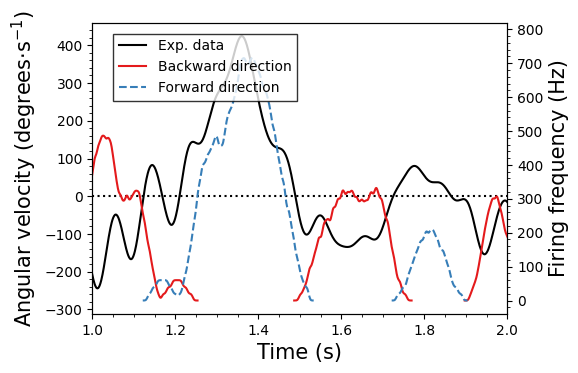

In [35]:
with open('data/joint_angles_nostep', 'rb') as file:
    joint_angles_nostep = pickle.load(file) 
    
joint_angles = joint_angles_nostep[:, :, 0]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

firing_rate_down = get_firing_rate(spike_motion[:, 0, 0], constants['dt'], t=0.05)
firing_rate_up = get_firing_rate(spike_motion[:, 1, 0], constants['dt'], t=0.05)

ax1.plot(time[1:], np.diff(joint_angles[:, 0]) / constants['dt'], color='black', linestyle=custom_linestyles[0], label='Exp. data')
ax2.plot(time, firing_rate_down, color=custom_colors[0], linestyle=custom_linestyles[0], label='Backward direction')
ax2.plot(time, firing_rate_up, color=custom_colors[1], linestyle=custom_linestyles[1], label='Forward direction')
ax1.plot(time, np.full(time.size, 0), color='black', linestyle='dotted')

ax1.set_xlim([1, 2])
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Angular velocity (degrees$\cdot$s$^{-1}$)")
ax2.set_ylabel("Firing frequency (Hz)")

ax1.minorticks_on()
ax2.minorticks_on()

fig.legend(loc='upper left', fancybox=False, edgecolor='black', bbox_to_anchor=[0.18, 0.97])

fig.tight_layout(pad=0.5)
fig.savefig('images/motion_neuron/motion_binary.png')
fig.savefig('images/motion_neuron/motion_binary.pdf')

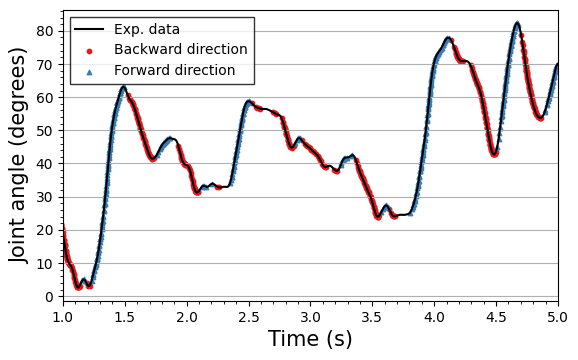

In [36]:
spike_motion[spike_motion == 0] = np.nan

fig, ax = plt.subplots()

plt.plot(time, joint_angles[:, 0], color='black')
plt.scatter(time, joint_angles[:, 0] * spike_motion[:, 0, 0], color=custom_colors[0], marker=custom_markers[0], s=10)
plt.scatter(time, joint_angles[:, 0] * spike_motion[:, 1, 0], color=custom_colors[1], marker=custom_markers[1], s=10)

ax.set_xlim([1, 5])
ax.set_xlabel("Time (s)")
ax.set_ylabel("Joint angle (degrees)")

ax.grid(axis='y', zorder=0)

ax.minorticks_on()

ax.legend(['Exp. data', 'Backward direction', 'Forward direction'], fancybox=False, edgecolor='black')

fig.tight_layout(pad=0.5)
fig.savefig('images/motion_neuron/movement_interneuron_network.png')
fig.savefig('images/motion_neuron/movement_interneuron_network.pdf')